In [1]:
import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Compose
import skimage
import cv2

In [2]:
#original 512 x 512
i_width = 512
i_height = 512
input_shape = i_width*i_height

In [3]:
def AddImage(path):
  ds = dicom.dcmread(path)

  image = ds.pixel_array
  image = image.astype(np.int16)
  image[image == -2000] = 0
  
  # Convert to Hounsfield units (HU)
  intercept = ds.RescaleIntercept
  slope = ds.RescaleSlope
  
  if slope != 1:
      image = slope * image.astype(np.float64)
      image = image.astype(np.int16)
      
  image += np.int16(intercept)
  image =  np.array(image, dtype=np.float32)
  #resize for more faster nn learning
  #image = skimage.transform.resize(image, (i_height, i_width))
  return image

def AddImageToArray(x,folderPath):
  patchs = os.listdir(folderPath)
  for filename in sorted(patchs, key=len):
    f = os.path.join(folderPath, filename)
    if os.path.isfile(f):
      x.append(AddImage(os.path.join(folderPath, filename)))
    else:
      AddImageToArray(x,f)

In [4]:
x_trn = []
x_tst = []

AddImageToArray(x_trn ,'DICOM\skulls\skull8')
AddImageToArray(x_tst ,'DICOM\PA5\ST1\SE4')

x_trn = np.array(x_trn)
x_tst = np.array(x_tst)

In [5]:
max_value = np.max(x_trn)
print(max_value)
x_trn /= max_value
x_tst /= max_value

print(len(x_trn ))
print(x_trn.shape)
print(x_trn[0].max())

3063.0
234
(234, 512, 512)
0.43617368


In [6]:
x_trn = cv2.blur(x_trn, (7,7))
x_tst = cv2.blur(x_tst, (7,7))
print(x_trn[0].max())

0.2906514


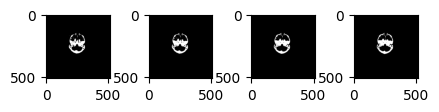

In [7]:
show_ratio = 0.04
k = 100
for i in range(4):
  plt.subplot(5,5, i+1)
  plt.imshow(np.where(x_trn[k] > show_ratio, 1, 0), cmap='gray')
  k+=1


In [8]:
x_trn = np.where(x_trn > show_ratio, 1, 0)
x_tst = np.where(x_tst > show_ratio, 1, 0)
x_trn = np.array(x_trn, np.float32)
x_tst = np.array(x_tst, np.float32)

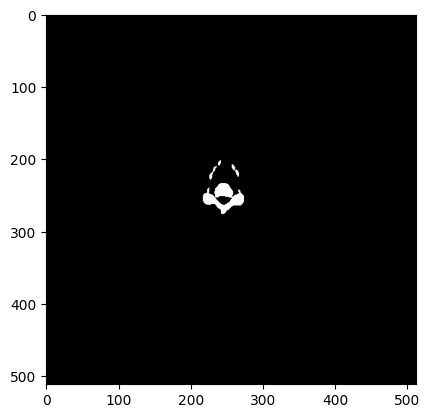

In [9]:
plt.imshow(x_trn[15], cmap='gray')

In [10]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=256
        )
        self.encoder_output_layer = nn.Linear(
            in_features=256, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [11]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=input_shape).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [12]:
def train(epochs, model, criterion, optimizer, train_loader):
    for epoch in range(epochs):
        loss = 0
        for batch_features in train_loader:
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
            batch_features = batch_features.view(-1, input_shape).to(device)
            
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            # compute reconstructions
            outputs = model(batch_features)
            
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(train_loader)
        
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    
    return model

In [13]:
transform = Compose([ToTensor()])

train_loader = torch.utils.data.DataLoader(
    x_trn, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    x_tst, batch_size=32, shuffle=False, num_workers=4
)

In [14]:
model = train(100, model, criterion, optimizer, train_loader)

epoch : 1/100, loss = 0.025108
epoch : 2/100, loss = 0.016573
epoch : 3/100, loss = 0.015119
epoch : 4/100, loss = 0.013387
epoch : 5/100, loss = 0.012238
epoch : 6/100, loss = 0.011050
epoch : 7/100, loss = 0.009921
epoch : 8/100, loss = 0.008895
epoch : 9/100, loss = 0.007921
epoch : 10/100, loss = 0.007166
epoch : 11/100, loss = 0.006475
epoch : 12/100, loss = 0.005831
epoch : 13/100, loss = 0.005240
epoch : 14/100, loss = 0.004736
epoch : 15/100, loss = 0.004295
epoch : 16/100, loss = 0.003939
epoch : 17/100, loss = 0.003653
epoch : 18/100, loss = 0.003444
epoch : 19/100, loss = 0.003266
epoch : 20/100, loss = 0.003158
epoch : 21/100, loss = 0.003044
epoch : 22/100, loss = 0.002945
epoch : 23/100, loss = 0.002842
epoch : 24/100, loss = 0.002785
epoch : 25/100, loss = 0.002727
epoch : 26/100, loss = 0.002691
epoch : 27/100, loss = 0.002617
epoch : 28/100, loss = 0.002569
epoch : 29/100, loss = 0.002523
epoch : 30/100, loss = 0.002492
epoch : 31/100, loss = 0.002446
epoch : 32/100, l

KeyboardInterrupt: 

In [15]:
test_examples = []
with torch.no_grad():
    for batch_features in test_loader:
        test_examples = np.array(batch_features)
        batch_features = batch_features.view(-1, input_shape).to(device)
        reconstruction = model(batch_features)
        break

<Figure size 2500x2500 with 0 Axes>

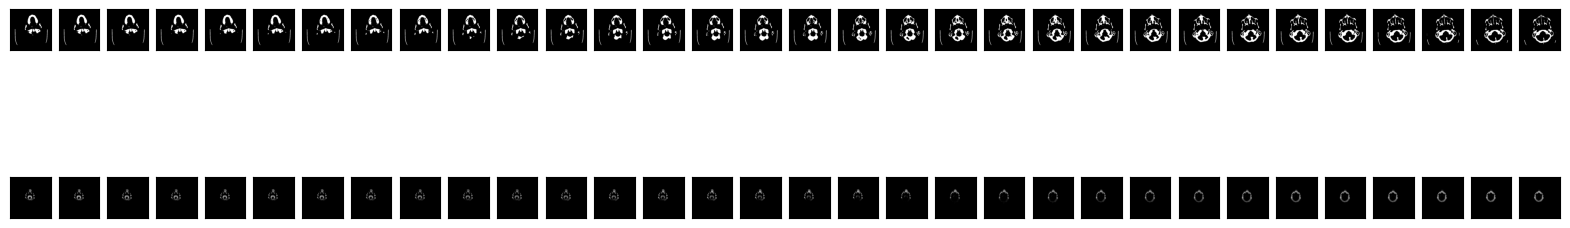

In [17]:
plt.figure(figsize=(25,25))
with torch.no_grad():
    number = 32
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].reshape(i_height, i_width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(i_height, i_width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

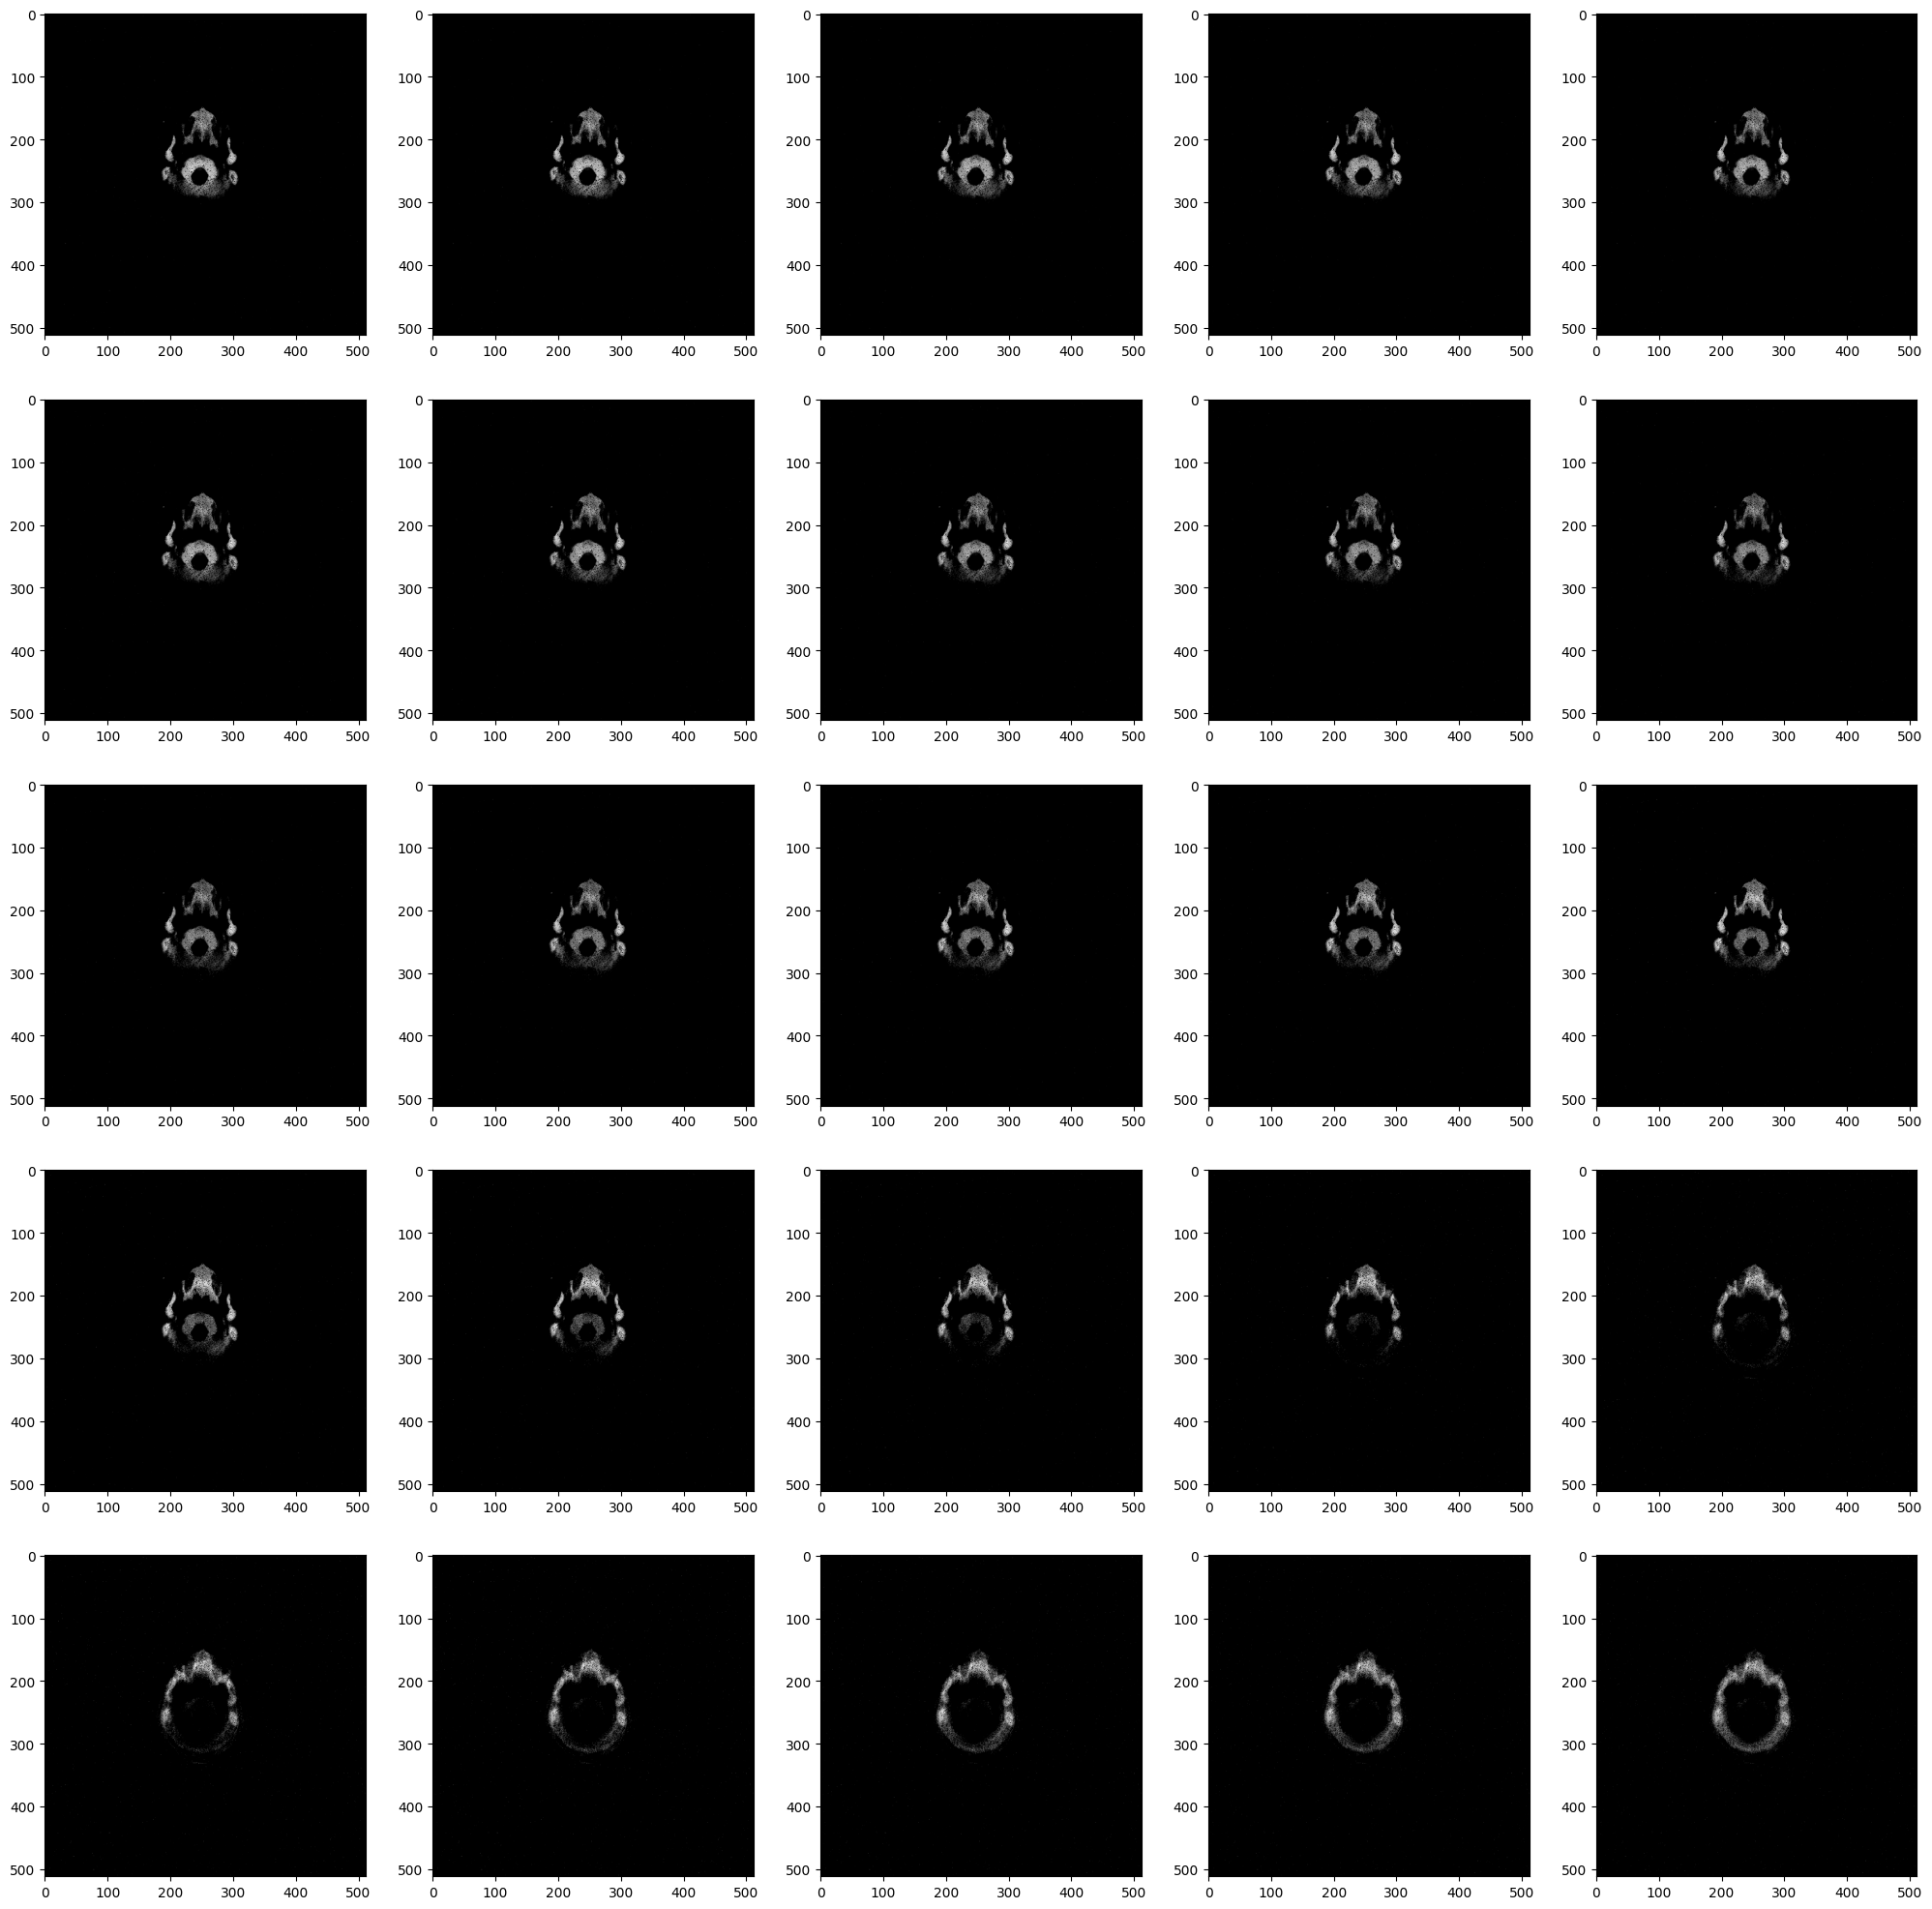

In [20]:
k = 0
plt.figure(figsize=(25,25))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.imshow(reconstruction[k].numpy().reshape(i_height, i_width), cmap='gray')
  k+=1

plt.show()

In [ ]:
k = 0
plt.figure(figsize=(25,25))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.imshow(reconstruction[k].numpy().reshape(i_height, i_width), cmap='gray')
  k+=1

plt.show()